In [2]:
import math

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

random_seed = 30

In [3]:
data = pd.read_csv("../data/featured/data.csv", sep=';')

Xdata = data.drop('win', axis=1)
ydata = data.win

In [4]:
Xtrain, Xval, ytrain, yval = train_test_split(Xdata, ydata, test_size=0.4, random_state=random_seed)

In [5]:
clfRF = RandomForestClassifier(n_estimators = 20, max_depth = 8, random_state = random_seed)
clfRF.fit(Xtrain, ytrain)

print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clfRF.predict(Xtrain))))
print('Accuracy score (val): {0:.6f}'.format(metrics.accuracy_score(yval, clfRF.predict(Xval))))

Accuracy score (train): 0.976247
Accuracy score (val): 0.648936


In [6]:
param_grid = {
    'n_estimators': range(25,50),
    'max_depth': range(5, 15)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clfRF = RandomForestClassifier(**params, random_state = random_seed).fit(Xtrain, ytrain)
    val_metric.append(metrics.accuracy_score(yval, clfRF.predict(Xval)))
    
best_params = param_comb[np.argmax(val_metric)]
print(f"We found the best params {best_params} with validation acuraccy {max(val_metric):.4f}.")

We found the best params {'n_estimators': 30, 'max_depth': 14} with validation acuraccy 0.7092.


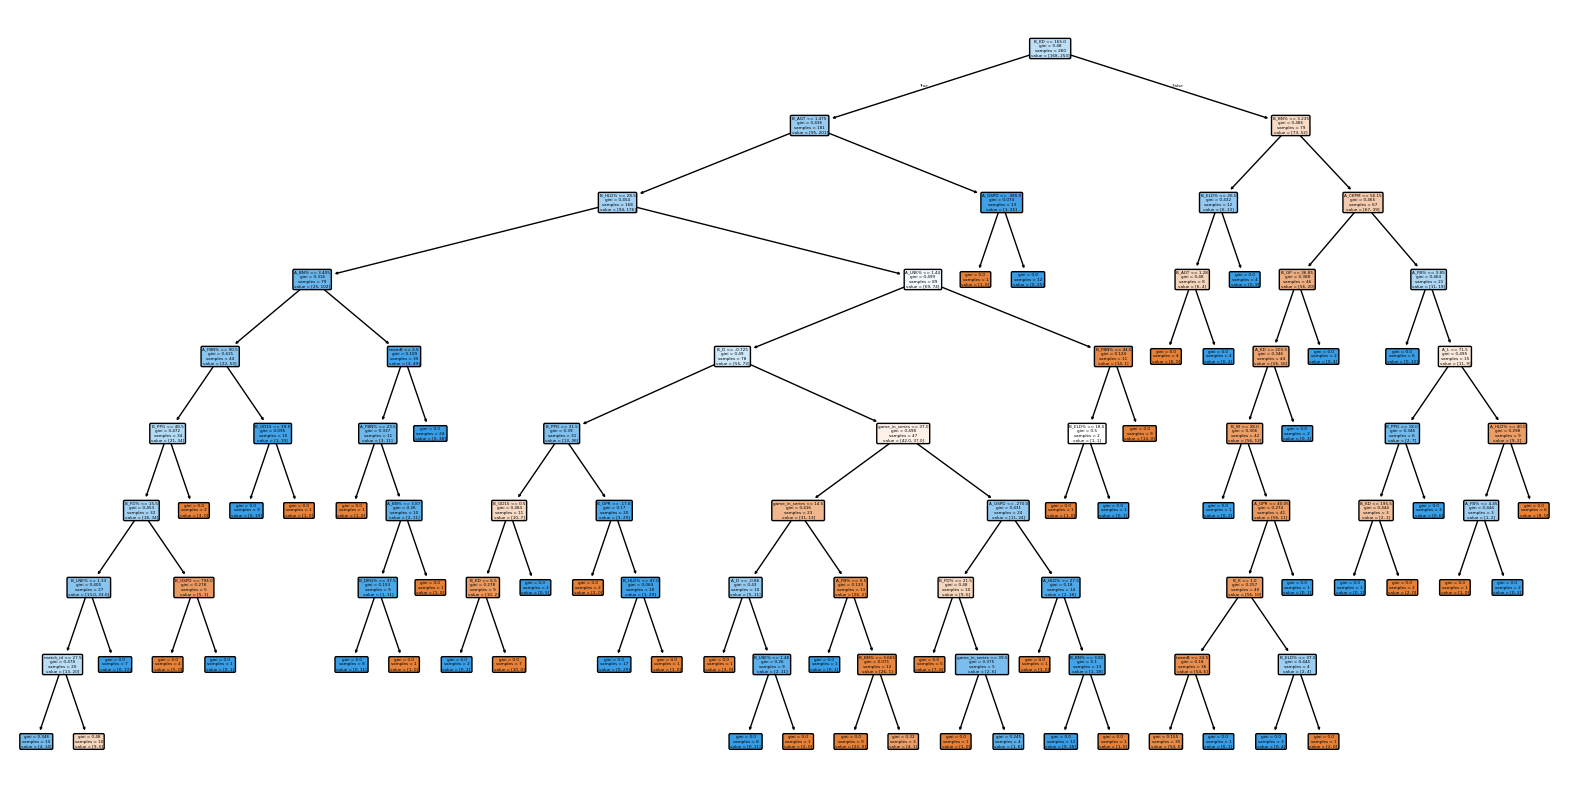

In [7]:
from sklearn import tree
import matplotlib.pyplot as plt

clfRF = RandomForestClassifier(n_estimators=45, max_depth=9, random_state = random_seed).fit(Xtrain, ytrain)

estimator = clfRF.estimators_[0]
feature_names = ["match_id","game_in_series","teamA","teamB","teamA_win","A_GP","A_W","A_L","A_AGT","A_K","A_D","A_KD","A_CKPM","A_GPR","A_GSPD","A_EGR","A_MLR","A_GD15","A_FB%","A_FT%","A_F3T%","A_PPG","A_HLD%","A_GRB%","A_FD%","A_DRG%","A_ELD%","A_FBN%","A_BN%","A_LNE%","A_JNG%","A_WPM","A_CWPM","A_WCPM","B_GP","B_W","B_L","B_AGT","B_K","B_D","B_KD","B_CKPM","B_GPR","B_GSPD","B_EGR","B_MLR","B_GD15","B_FB%","B_FT%","B_F3T%","B_PPG","B_HLD%","B_GRB%","B_FD%","B_DRG%","B_ELD%","B_FBN%","B_BN%","B_LNE%","B_JNG%","B_WPM","B_CWPM","B_WCPM","tournament","year","month","day"]


plt.figure(figsize=(20, 10))
tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    rounded=True
)
plt.show()
